In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
from threading import Thread, RLock
import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import tensorflow as tf
import keras
%matplotlib inline

In [3]:
df = pd.read_csv('grenoble_7.k7.csv',
                 parse_dates=['datetime'],
                 infer_datetime_format=True,
                 index_col='datetime')              

In [4]:
df

,src,dst,channel,mean_rssi,pdr,tx_count
datetime,,,,,,
2018-01-11 16:32:22,0,18,11,-5.90,1.0,100
2018-01-11 16:32:22,0,7,11,-70.74,1.0,100
2018-01-11 16:32:22,0,42,11,-80.06,0.6,100
2018-01-11 16:32:22,0,28,11,-68.46,1.0,100
2018-01-11 16:32:22,0,12,11,-71.84,0.6,100
...,...,...,...,...,...,...
2018-01-13 16:21:20,49,28,26,-75.13,1.0,100
2018-01-13 16:21:20,49,37,26,-68.39,1.0,100
2018-01-13 16:21:20,49,13,26,-74.39,1.0,100


In [5]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
target_names=[]

                                           # for pdr+rssi
combined_features=[]
for i in range(len(df)):
        combined_features.append(df['pdr'][i]*df['pdr'][i]+df['mean_rssi'][i]*df['mean_rssi'][i])
        if df['pdr'][i] <= 0.3:
            target_names.append('Bad')
        elif df['pdr'][i]>=0.75:
            target_names.append('Good')
        elif ((df['pdr'][i]>0.3 and df['pdr'][i]<0.75)and df['mean_rssi'][i]<=-87):
            target_names.append('Bad')
        else:
            target_names.append('Interm.')

df['combined_features']=combined_features
coloumn=['combined_features']

    
df['target_names']=target_names
coloumn2=['target_names']

In [6]:
df

,src,dst,channel,mean_rssi,pdr,tx_count,combined_features,target_names
datetime,,,,,,,,
2018-01-11 16:32:22,0,18,11,-5.90,1.0,100,35.8100,Good
2018-01-11 16:32:22,0,7,11,-70.74,1.0,100,5005.1476,Good
2018-01-11 16:32:22,0,42,11,-80.06,0.6,100,6409.9636,Interm.
2018-01-11 16:32:22,0,28,11,-68.46,1.0,100,4687.7716,Good
2018-01-11 16:32:22,0,12,11,-71.84,0.6,100,5161.3456,Interm.
...,...,...,...,...,...,...,...,...
2018-01-13 16:21:20,49,28,26,-75.13,1.0,100,5645.5169,Good
2018-01-13 16:21:20,49,37,26,-68.39,1.0,100,4678.1921,Good
2018-01-13 16:21:20,49,13,26,-74.39,1.0,100,5534.8721,Good


In [7]:
target_names = np.array('target_names')

In [8]:
count_bad=(df['target_names']=='Bad').sum()
print(count_bad)

10220


In [9]:
count_interm=(df['target_names']=='Interm.').sum()
print(count_interm)

13017


In [10]:
count_good=(df['target_names']=='Good').sum()
print(count_good)

85422


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108659 entries, 2018-01-11 16:32:22 to 2018-01-13 16:21:20
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   src                108659 non-null  int64  
 1   dst                108659 non-null  int64  
 2   channel            108659 non-null  int64  
 3   mean_rssi          108659 non-null  float64
 4   pdr                108659 non-null  float64
 5   tx_count           108659 non-null  int64  
 6   combined_features  108659 non-null  float64
 7   target_names       108659 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 7.5+ MB


In [12]:
df.shape

(108659, 8)

In [13]:
df.describe()

,src,dst,channel,mean_rssi,pdr,tx_count,combined_features
count,108659.000000,108659.000000,108659.000000,108659.000000,108659.000000,108659.0,108659.000000
mean,24.923485,25.047387,18.376895,-74.550728,0.874964,100.0,5699.554141
std,14.831090,14.836094,4.579974,11.870855,0.248361,0.0,1656.734295
min,0.000000,0.000000,11.000000,-91.000000,0.010000,100.0,35.810000
25%,12.000000,13.000000,14.000000,-85.770000,0.910000,100.0,4485.980900
50%,25.000000,25.000000,18.000000,-76.570000,1.000000,100.0,5863.964900
75%,39.000000,40.000000,22.000000,-66.970000,1.000000,100.0,7357.492900
max,49.000000,49.000000,26.000000,-5.900000,1.000000,100.0,8281.000100


In [14]:
features = df[['combined_features']]
target_names = df[['target_names']]              

In [15]:
features

,combined_features
datetime,
2018-01-11 16:32:22,35.8100
2018-01-11 16:32:22,5005.1476
2018-01-11 16:32:22,6409.9636
2018-01-11 16:32:22,4687.7716
2018-01-11 16:32:22,5161.3456
...,...
2018-01-13 16:21:20,5645.5169
2018-01-13 16:21:20,4678.1921
2018-01-13 16:21:20,5534.8721


In [16]:
#from sklearn.model_selection import train_test_split
#train_features,test_features,train_labels,test_labels = train_test_split(features,target_names,test_size=0.3,shuffle=False)

In [17]:
#train_labels

In [18]:
#test_labels

In [19]:
# Split train and test data
train_features = features.loc['2018-01-11 16:32:22':'2018-01-13 06:43:02']
train_labels = target_names.loc['2018-01-11 16:32:22':'2018-01-13 06:43:02','target_names']

test_features = features.loc['2018-01-13 06:43:02':'2018-01-13 16:21:20']
test_labels = target_names.loc['2018-01-13 06:43:02':'2018-01-13 16:21:20','target_names']

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window

T = 30  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((86928, 1), (86928,), (21763, 1), (21734,))

In [20]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)

scaled_train_features.shape, scaled_test_features.shape

((86928, 1), (21763, 1))

In [21]:
scaled_train_features

,combined_features
datetime,
2018-01-11 16:32:22,-3.419235
2018-01-11 16:32:22,-0.419327
2018-01-11 16:32:22,0.428737
2018-01-11 16:32:22,-0.610922
2018-01-11 16:32:22,-0.325033
...,...
2018-01-13 06:42:51,-1.045750
2018-01-13 06:42:51,0.893700
2018-01-13 06:43:02,-1.013707


In [22]:
scaled_test_features

,combined_features
datetime,
2018-01-13 06:42:29,-0.616705
2018-01-13 06:42:29,1.229850
2018-01-13 06:42:29,-0.486424
2018-01-13 06:42:29,1.155886
2018-01-13 06:42:30,1.363519
...,...
2018-01-13 16:21:20,-0.032747
2018-01-13 16:21:20,-0.616705
2018-01-13 16:21:20,-0.099541


In [23]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (86899, 30, 1), (86899, 1)
Test data dimensions: (21734, 30, 1), (21734, 1)


In [24]:
y_train = pd.DataFrame(y_train)
y_train.head(102)

,0
0,Good
1,Good
2,Good
3,Good
4,Good
...,...
97,Good
98,Interm.
99,Good
100,Good


In [25]:
y_train = pd.DataFrame(y_train)
y_train = pd.get_dummies(y_train)

In [26]:
y_train

,0_Bad,0_Good,0_Interm.
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
86894,0,1,0
86895,0,1,0
86896,0,1,0
86897,0,1,0


In [27]:
y_train = np.array(y_train)
print(y_train.shape)
y_train

(86899, 3)


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [28]:
y_test = pd.DataFrame(y_test)
y_test = pd.get_dummies(y_test)
y_test 

,0_Bad,0_Good,0_Interm.
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,1,0,0
...,...,...,...
21729,0,1,0
21730,0,1,0
21731,0,1,0
21732,0,1,0


In [29]:
y_test = np.array(y_test)
print(y_test.shape)
y_test

(21734, 3)


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [30]:
#X_train = X_train.reshape(-1, 1, 1)
#X_test  = X_test.reshape(-1, 30, 3)
#y_train = y_train.reshape(-1, , 3)
#y_test = y_test.reshape(-1, 30, 3)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(86899, 30, 1)
(21734, 30, 1)
(86899, 3)
(21734, 3)


In [32]:
T

30

In [33]:
#from keras.layers.recurrent import LSTM
#N = X_train.shape[2]

#model = keras.models.Sequential()
#model.add(LSTM(1, input_shape=(T,N),return_sequences=True))
#model.add(keras.layers.Dense(3, activation='softmax'))

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [35]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH =  10                         # number of epochs
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=True, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=True, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='sigmoid',
               kernel_regularizer=None, recurrent_regularizer=None,
               return_sequences=False, recurrent_dropout=RDP, dropout=DP
               ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='softmax'))

print(model.summary())

layers=[8, 8, 8, 3], train_examples=86899, test_examples=21734
batch = 86899, timesteps = 30, features = 1, epochs = 10
dropout = 0.0, recurr_dropout = 0.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 8)             320       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 8)             32        
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 8)             544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
batch_normalization_2 (Batch (No

In [36]:
# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [37]:
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    verbose=2)

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=1)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


Epoch 1/10
2716/2716 - 103s - loss: 0.4692 - accuracy: 0.8229 - val_loss: 0.4715 - val_accuracy: 0.7895
Epoch 2/10
2716/2716 - 74s - loss: 0.3204 - accuracy: 0.8786 - val_loss: 0.2632 - val_accuracy: 0.9040
Epoch 3/10
2716/2716 - 74s - loss: 0.2926 - accuracy: 0.8906 - val_loss: 0.2463 - val_accuracy: 0.9134
Epoch 4/10
2716/2716 - 74s - loss: 0.2806 - accuracy: 0.8952 - val_loss: 0.2955 - val_accuracy: 0.8799
Epoch 5/10
2716/2716 - 74s - loss: 0.2682 - accuracy: 0.8997 - val_loss: 0.2240 - val_accuracy: 0.9182
Epoch 6/10
2716/2716 - 74s - loss: 0.2642 - accuracy: 0.9007 - val_loss: 0.2233 - val_accuracy: 0.9193
Epoch 7/10
2716/2716 - 74s - loss: 0.2573 - accuracy: 0.9029 - val_loss: 0.3023 - val_accuracy: 0.8842
Epoch 8/10
2716/2716 - 74s - loss: 0.2521 - accuracy: 0.9052 - val_loss: 0.3255 - val_accuracy: 0.8784
Epoch 9/10
2716/2716 - 73s - loss: 0.2513 - accuracy: 0.9060 - val_loss: 0.2086 - val_accuracy: 0.9233
Epoch 10/10
2716/2716 - 73s - loss: 0.2478 - accuracy: 0.9062 - val_loss

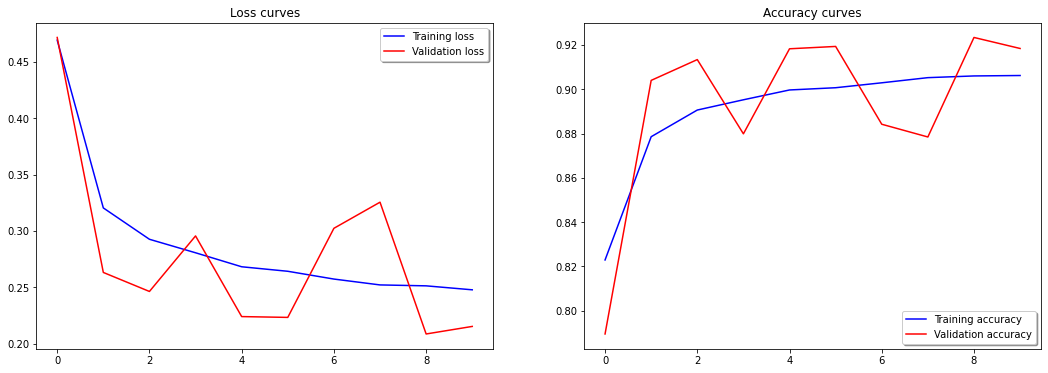

In [55]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [56]:
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [57]:
#history  = model.fit(X_train,y_train,epochs=2,batch_size=32,validation_data=(X_test,y_test))

In [58]:
#model.evaluate(X_test,y_test)

In [59]:
#y_pred = model.predict(X_test)

In [60]:
#y_pred

In [61]:
#predict_class = np.argmax(y_pred, axis=1)
#predict_class = predict_class

In [62]:
#predict_class

In [63]:
#from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
#classifier.fit(X_train, y_train)

In [64]:
#y_pred = np.array(y_train)
#y_test = np.array(y_test)

In [65]:
#y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

In [66]:
#from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
#conf = confusion_matrix(y_pred,y_test)
#acc = accuracy_score(y_pred,y_test)
#report = classification_report(y_pred,y_test)

In [67]:
#print(report)

In [68]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [52]:
y_test = pd.DataFrame(y_test)
y_test=np.argmax(y_test.iloc[:,:].values, axis=1)
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
y_pred = np.argmax(model.predict(X_test, batch_size=M_TEST, verbose=1),axis=-1)
#score = sum(y_pred == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2019-01-13 06:43:02', end='2019-01-13 16:43:02', freq='H')
for i in range(y_pred.shape[0]):
    print(index[i], y_pred[i], y_test[i])

1/1 [==============================] - 0s 47ms/step
2019-01-13 06:43:02 1 1
2019-01-13 07:43:02 1 1
2019-01-13 08:43:02 1 1
2019-01-13 09:43:02 0 2
2019-01-13 10:43:02 0 0
2019-01-13 11:43:02 2 2
2019-01-13 12:43:02 1 2
2019-01-13 13:43:02 2 2
2019-01-13 14:43:02 1 1
2019-01-13 15:43:02 1 1
2019-01-13 16:43:02 1 1


IndexError: ignored

In [74]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [73]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [75]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
conf = confusion_matrix(y_pred,y_test)
acc = accuracy_score(y_pred,y_test)*100
report = classification_report(y_pred,y_test)

In [76]:
print(conf)

[[ 1923     0   100]
 [    1 16974  1345]
 [   27   301  1063]]


In [77]:
print(f'{acc:.2f} %')

91.84 %


In [78]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2023
           1       0.98      0.93      0.95     18320
           2       0.42      0.76      0.55      1391

    accuracy                           0.92     21734
   macro avg       0.80      0.88      0.82     21734
weighted avg       0.95      0.92      0.93     21734



In [79]:
y_pred = y_pred.astype(object)
y_pred[y_pred==0] = 'Bad'
y_pred[y_pred==1] = 'Good'
y_pred[y_pred==2] = 'Interm'

In [80]:
y_pred

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [81]:
y_test= y_test.astype(object)
y_test[y_test==0] = 'Bad'
y_test[y_test==1] = 'Good'
y_test[y_test==2] = 'Interm'

In [82]:
y_test

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [83]:
comparision=np.concatenate((y_test.reshape(len(y_test),1), y_pred.reshape(len(y_pred),1)),1)
print(comparision)

[['Good' 'Good']
 ['Good' 'Good']
 ['Good' 'Good']
 ...
 ['Good' 'Good']
 ['Good' 'Good']
 ['Good' 'Good']]


In [87]:
score = sum(y_pred == y_test) / len(y_test)
print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2019-01-13 06:43:02', end='2019-01-13 16:43:02', freq='H')
for i in range(y_pred.shape[0]):
   print(index[i], y_pred[i])

Prediction accuracy = 91.83767369099107%
2019-01-13 06:43:02 Good
2019-01-13 07:43:02 Good
2019-01-13 08:43:02 Good
2019-01-13 09:43:02 Bad
2019-01-13 10:43:02 Bad
2019-01-13 11:43:02 Interm
2019-01-13 12:43:02 Good
2019-01-13 13:43:02 Interm
2019-01-13 14:43:02 Good
2019-01-13 15:43:02 Good
2019-01-13 16:43:02 Good


IndexError: ignored